In [139]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import astropy.units as u
from astropy.modeling.models import BlackBody
from scipy.optimize import curve_fit, minimize

We are following the following equation to get to a BB spectrum:

$$
D(\nu) = e^{i\nu\psi} H(\nu)^{-1} \left(\frac{1}{Z(\omega)B(\omega)} Y(\nu) - C(\nu)\right).
$$

In [140]:
f_nyquist = 145.212 / u.cm # from explanatory supplement
nu = np.arange(210)*(f_nyquist/320) + 2 / u.cm
# nu = nu[:43]
print(max(nu))

f = nu.to(u.GHz, equivalencies=u.spectral())
print(max(f))

x = np.linspace(1e-15, 1.22, 512) * u.cm
print(max(x))

96.84158749999999 1 / cm
2903.237755324707 GHz
1.22 cm


Get interferograms

In [141]:
# gmt = b'89326172801540'
# gmt = b'1990-01-19 08:14:04' # xcal in, both at around 2.75K
gmt = b'1989-12-20 23:46:11' # xcal in, ical 15K, xcal 8K

# fdq_sdf = h5py.File("/mn/stornext/d16/cmbco/ola/firas/initial_data/fdq_sdf_new.h5")["fdq_sdf_ll"]
# fdq_eng = h5py.File("/mn/stornext/d16/cmbco/ola/firas/initial_data/fdq_eng_new.h5")

# sci_id = list(fdq_sdf["ct_head/gmt"]).index(gmt)

# print(sci_id)

# get ifgs from cleaned data
# data = h5py.File("./../../data/df_v11.h5", "r")
data = h5py.File("/mn/stornext/u3/duncanwa/Commander_debugging/commander3/todscripts/firas/data/df_v11.h5", "r")

# get id of the given gmt
idx = list(data["df_data/gmt"]).index(gmt)

In [142]:
data["df_data/pix_cel"][idx]

np.float64(11025.0)

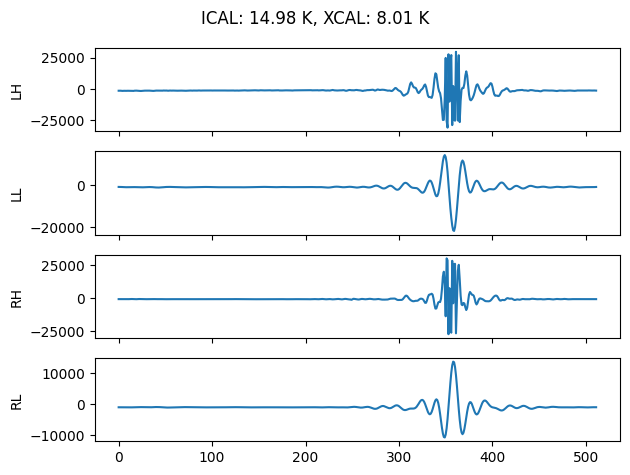

In [143]:
fig, ax = plt.subplots(sharex=True, nrows=4)
fig.subplots_adjust(hspace=0)

ax[0].plot(data["df_data/ifg_lh"][idx])
ax[1].plot(data["df_data/ifg_ll"][idx])
ax[2].plot(data["df_data/ifg_rh"][idx])
ax[3].plot(data["df_data/ifg_rl"][idx])

ax[0].set_ylabel("LH")
ax[1].set_ylabel("LL")
ax[2].set_ylabel("RH")
ax[3].set_ylabel("RL")

fig.suptitle(
    f"ICAL: {data['df_data/ical'][idx]:.2f} K, XCAL: {data['df_data/xcal'][idx]:.2f} K"
)

plt.tight_layout()
plt.show()

In [144]:
# eng_time = fdq_sdf["dq_data/eng_time"][sci_id]
# eng_id = list(fdq_eng["ct_head/time"]).index(eng_time)

# print(eng_id)

In [145]:
# xcal_pos = fdq_sdf["dq_data/xcal_pos"][sci_id]
# print(xcal_pos)

In [146]:
# mtm_length = fdq_sdf["sci_head/mtm_length"][sci_id]
mtm_length = data["df_data/mtm_length"][idx]
# mtm_speed = fdq_sdf["sci_head/mtm_speed"][sci_id]
mtm_speed = data["df_data/mtm_speed"][idx]

In [147]:
# fake_it = fdq_sdf["dq_data/fake"][sci_id]
fake_it = 0

In [148]:
# upmode = fdq_sdf["sci_head/sc_head1a"][sci_id]
upmode = 4

In [149]:
# adds_per_group = fdq_sdf["sci_head/sc_head9"][sci_id]
adds_per_group = data["df_data/adds_per_group"][idx]

In [150]:
# ifg = fdq_sdf["ifg_data/ifg"][sci_id]

ifg_lh = data["df_data/ifg_lh"][idx]
ifg_ll = data["df_data/ifg_ll"][idx]
ifg_rh = data["df_data/ifg_rh"][idx]
ifg_rl = data["df_data/ifg_rl"][idx]

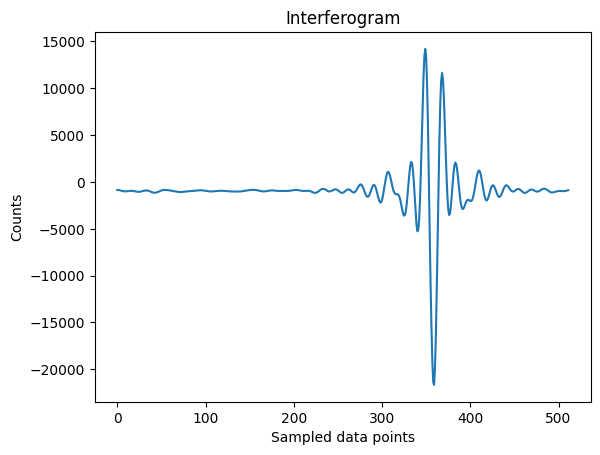

In [151]:
plt.plot(ifg_ll)
plt.xlabel("Sampled data points")
plt.ylabel("Counts")
plt.title("Interferogram")
plt.show()

Subtract the dither

In [152]:
ifg_ll = ifg_ll - np.median(ifg_ll)

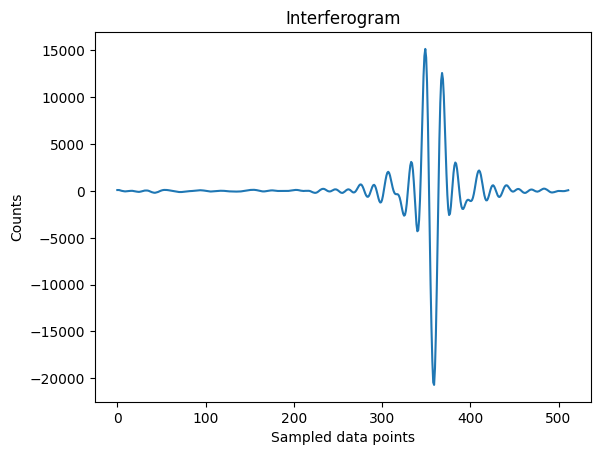

In [153]:
plt.plot(ifg_ll)
plt.xlabel("Sampled data points")
plt.ylabel("Counts")
plt.title("Interferogram")
plt.show()

Get rid of the biggest glitches

In [154]:
# ifg_maxs = copy.deepcopy(ifg)

# ordered_maxs = []
# for i in range(len(ifg)):
#     ordered_maxs.append(np.argmax(np.abs(ifg_maxs)))
#     ifg_maxs[ordered_maxs[-1]] = 0

# plt.vlines(ordered_maxs[26], np.min(ifg), np.max(ifg), color="red")
# plt.vlines(ordered_maxs[30], np.min(ifg), np.max(ifg), color="red")
# plt.vlines(ordered_maxs[34], np.min(ifg), np.max(ifg), color="red")
# plt.vlines(ordered_maxs[37], np.min(ifg), np.max(ifg), color="red")
# plt.vlines(ordered_maxs[42:45], np.min(ifg), np.max(ifg), color="red")
# plt.vlines(ordered_maxs[49], np.min(ifg), np.max(ifg), color="red")
# plt.vlines(ordered_maxs[53], np.min(ifg), np.max(ifg), color="red")
# plt.vlines(ordered_maxs[58:60], np.min(ifg), np.max(ifg), color="red")
# plt.vlines(ordered_maxs[62:64], np.min(ifg), np.max(ifg), color="red")
# plt.vlines(ordered_maxs[68], np.min(ifg), np.max(ifg), color="red")
# plt.vlines(ordered_maxs[71:74], np.min(ifg), np.max(ifg), color="red")

# plt.plot(ifg)
# plt.xlabel("Sampled data points")
# plt.ylabel("Counts")
# plt.title("Interferogram")
# plt.show()

In [155]:
# averaged_ifg = copy.deepcopy(ifg)

# for i in range(len(ifg)//2):
#     averaged_ifg[ordered_maxs[i]] = 0

# print(np.max(averaged_ifg), np.min(averaged_ifg))

# # plt.plot(averaged_ifg)
# # plt.xlabel("Sampled data points")
# # plt.ylabel("Counts")
# # plt.title("Averaged interferogram")
# # plt.show()

In [156]:
# std = np.std(averaged_ifg)

# glitch_idx = [26, 30, 34, 37, 42, 43, 44, 49, 53, 58, 59, 62, 63, 68, 71, 72, 73]
# deglitched_ifg = copy.deepcopy(ifg)

# for i in glitch_idx:
#     deglitched_ifg[ordered_maxs[i]] = np.random.normal(0, std)

# plt.plot(deglitched_ifg)
# plt.xlabel("Sampled data points")
# plt.ylabel("Counts")
# plt.title("Deglitched interferogram")
# plt.show()

## Find glitches

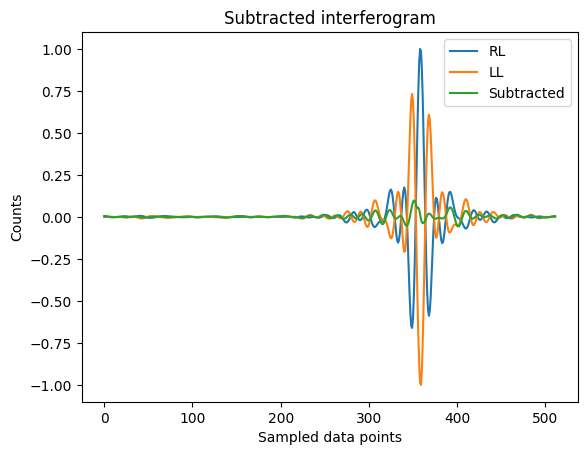

In [157]:
ifg_rl = ifg_rl - np.median(ifg_rl)
ifg_rl_norm = ifg_rl / np.max(np.abs(ifg_rl))

ifg_ll = ifg_ll - np.median(ifg_ll)
ifg_ll_norm = ifg_ll / np.max(np.abs(ifg_ll))

sub = ifg_rl_norm + ifg_ll_norm

plt.plot(ifg_rl_norm, label="RL")
plt.plot(ifg_ll_norm, label="LL")
plt.plot(sub, label="Subtracted")
plt.xlabel("Sampled data points")
plt.ylabel("Counts")
plt.title("Subtracted interferogram")
plt.legend()
plt.show()

In [158]:
# determine level of white noise
# noise = np.std(deglitched_ifg)
noise = np.std(sub)

# find glitches in the data
# glitches = np.where(np.abs(deglitched_ifg) > 5*noise)
glitches = np.where(np.abs(sub) > 5*noise)

tmp = glitches[0][0]
tmp_arr = np.array([tmp])
identified_glitches = np.array([])

j = 0

for i in glitches[0]:
    if i == tmp + 1:
        tmp_arr = np.append(tmp_arr, i)
    elif i - tmp > 1:
        max_pos = np.argmax(np.abs(sub[tmp_arr]))
        identified_glitches = np.append(identified_glitches, tmp_arr[max_pos])
        tmp_arr = np.array([i])
        tmp = i
    j += 1

# handle the last sequence of glitches
if len(tmp_arr) > 0:
    max_pos = np.argmax(np.abs(sub[tmp_arr]))
    identified_glitches = np.append(identified_glitches, tmp_arr[max_pos])

print(identified_glitches)

[351. 352.]


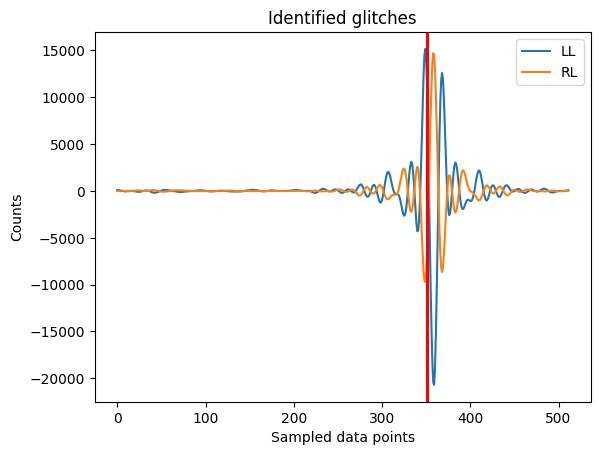

In [159]:
plt.plot(ifg_ll, label="LL")
plt.plot(ifg_rl, label="RL")
for glitch in identified_glitches:
    plt.axvline(x=glitch, color="red")
plt.xlabel("Sampled data points")
plt.ylabel("Counts")
plt.title("Identified glitches")
plt.legend()
plt.show()

Need to figure out a way to find which channel the glitches belong to, for now I will do it manually and just take the first glitch, which corresponds to the LL channel.

In [160]:
glitch_center = identified_glitches.astype(int)[0]
tmp = ifg_ll[glitch_center]

if ifg_ll[glitch_center] > 0:
    sign = 1
else:
    sign = -1

if sign == 1: # positive peaks
    for i in range(len(ifg_ll) - glitch_center): # finding end of glitch region
        if ifg_ll[glitch_center + i] > tmp or ifg_ll[glitch_center + i] < 0:
            glitch_end = glitch_center + i
            break
        else:
            tmp = ifg_ll[glitch_center + i]
    
    tmp = ifg_ll[glitch_center]
            
    for i in range(len(ifg_ll) - glitch_center): # finding beginning of glitch region
        if ifg_ll[glitch_center - i] > tmp or ifg_ll[glitch_center - i] < 0:
            glitch_start = glitch_center - i
            break
        else:
            tmp = ifg_ll[glitch_center - i]
elif sign == -1: # negative peaks
    for i in range(len(ifg_ll) - glitch_center): # finding end of glitch region
        if ifg_ll[glitch_center + i] < tmp or ifg_ll[glitch_center + i] > 0:
            glitch_end = glitch_center + i
            break
        else:
            tmp = ifg_ll[glitch_center + i]

    tmp = ifg_ll[glitch_center]
    
    for i in range(len(ifg_ll) - glitch_center): # finding beginning of glitch region
        if ifg_ll[glitch_center - i] < tmp or ifg_ll[glitch_center - i] > 0:
            glitch_start = glitch_center - i
            break
        else:
            tmp = ifg_ll[glitch_center - i]
    

print(glitch_start, glitch_end)

350 354


#### Electronics transfer function

In [161]:
from utils.frd import elex_transfcnl
from utils.fut import get_recnum

channel = 3 # (LL)

etfl_all = elex_transfcnl(samprate=681.43, nfreq=640//2+1)
erecno = int(get_recnum(fake_it, mtm_speed, channel, upmode, adds_per_group))
etf = etfl_all[erecno, :]

#### FITS data

In [162]:
fits_data = fits.open('./../../reference/FIRAS_CALIBRATION_MODEL_LLSS.FITS')

#### Glitch profile

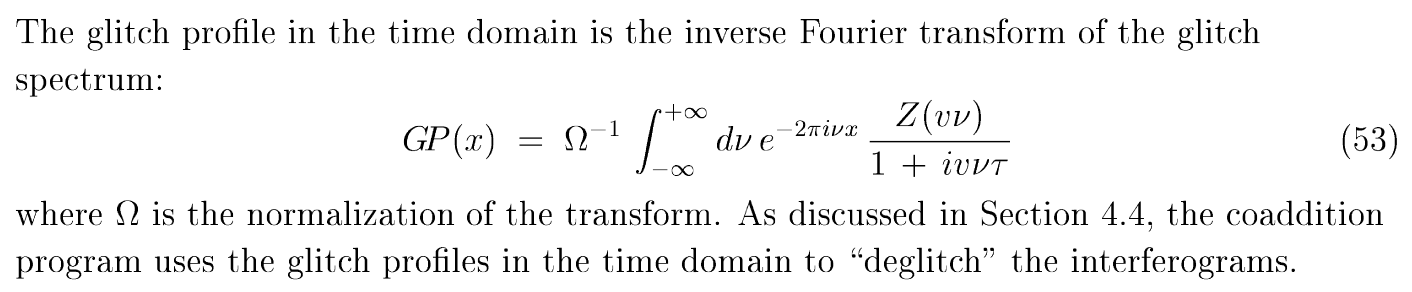

$$
GP(x) = \Omega^{-1}\int_{-\infty}^{\infty} d\nu\,e^{-2\pi i \nu x}\frac{Z(v\nu)}{1+iv\nu\tau}
$$

In [163]:
v = 0.8 * u.cm /u.s # slow speed
tau = fits_data[1].data['TIME_CON'][0] * u.s

def gp(x, omega):
    # re-map nu to be 512 points long and then crop to glitch region
    nu_512 = (np.linspace(0, 1, 512) * np.max(nu).value + 2) 
    nu_glitch = nu_512[glitch_start:glitch_end]

    v_array = np.full(nu_glitch.shape, v.value)
    tau_array = np.full(nu_glitch.shape, tau.value)

    result = -np.array([omega**(-1) * np.trapezoid(np.exp(-2*np.pi*1j*nu_glitch*xi) * etf[glitch_start:glitch_end]/(1 + 1j * v_array * nu_glitch * tau_array), nu_glitch) for xi in x])
    
    # Ensure the result is a numpy array of floats
    result = np.asarray(result, dtype=float)  
    return result

#### Fit glitch profile to data

##### Guess

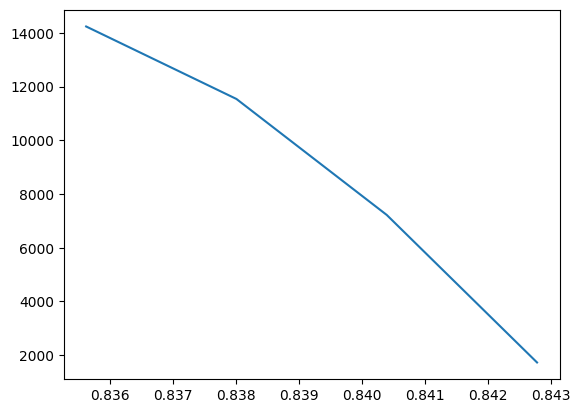

In [164]:
guess = 0.005

plt.plot(x[glitch_start:glitch_end], ifg_ll[glitch_start:glitch_end])
# plt.plot(x[glitch_start:glitch_end], gp(x[glitch_start:glitch_end].value, guess))
plt.show()

In [165]:
# fit = curve_fit(gp, x[glitch_start:glitch_end], ifg_ll[glitch_start:glitch_end], p0=[guess])[0]

In [166]:
# fit

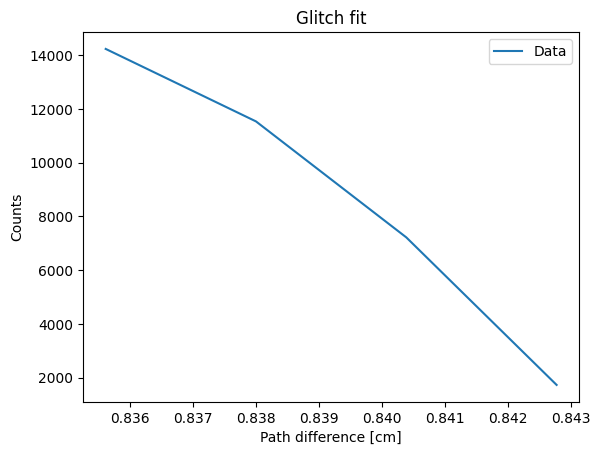

In [167]:
plt.plot(x[glitch_start:glitch_end], ifg_ll[glitch_start:glitch_end], label="Data")
# plt.plot(x[glitch_start:glitch_end], gp(x[glitch_start:glitch_end].value, fit), label="Fit")
plt.xlabel("Path difference [cm]")
plt.ylabel("Counts")
plt.title("Glitch fit")
plt.legend()
plt.show()

In [168]:
# deglitched_ifg = ifg_ll[glitch_start:glitch_end] - gp(x[glitch_start:glitch_end].value, fit)

# plt.plot(deglitched_ifg)
# plt.xlabel("Sampled data points")
# plt.ylabel("Counts")
# plt.title("Deglitched interferogram")
# plt.show()

In [169]:
# for now let's ignore the glitches
deglitched_ifg = ifg_ll

Apodize

In [170]:
from utils.fut import apod_recnuml

sm = 2 * mtm_length + mtm_speed
fake_it

arecno = int(apod_recnuml(channel, sm, fake_it, upmode, adds_per_group, 0))

In [171]:
from utils.frd import apodl

apodl_all = apodl()
apod = apodl_all[arecno, :]

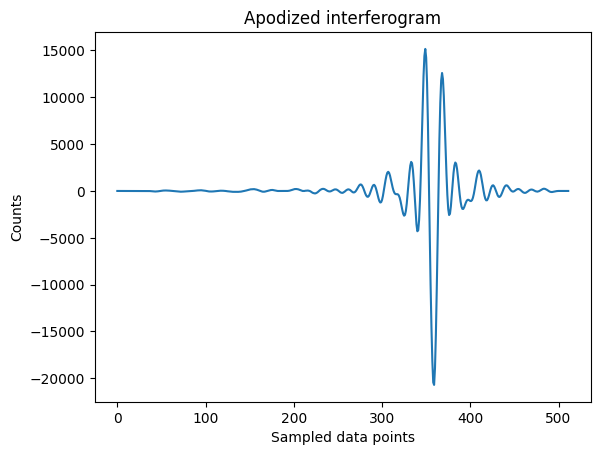

In [172]:
ai = apod * deglitched_ifg

plt.plot(ai)
plt.xlabel("Sampled data points")
plt.ylabel("Counts")
plt.title("Apodized interferogram")
plt.show()

Padding

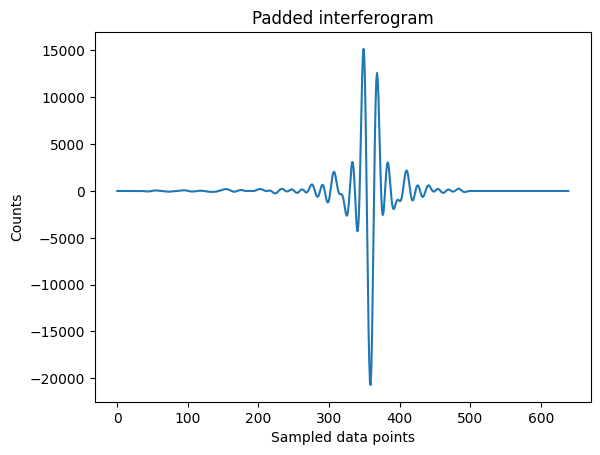

In [173]:
padding = np.zeros(640 - 512)
padded = np.concatenate((ai, padding))

plt.plot(padded)
plt.xlabel("Sampled data points")
plt.ylabel("Counts")
plt.title("Padded interferogram")
plt.show()

Roll

In [174]:
peak_pos = 360
rolled_ifg = np.roll(padded, -peak_pos)

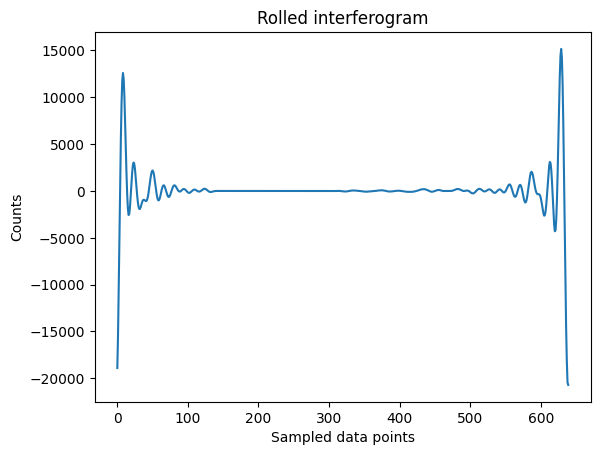

In [175]:
plt.plot(rolled_ifg)
plt.xlabel("Sampled data points")
plt.ylabel("Counts")
plt.title("Rolled interferogram")
plt.show()

Fourier transform

(321,)


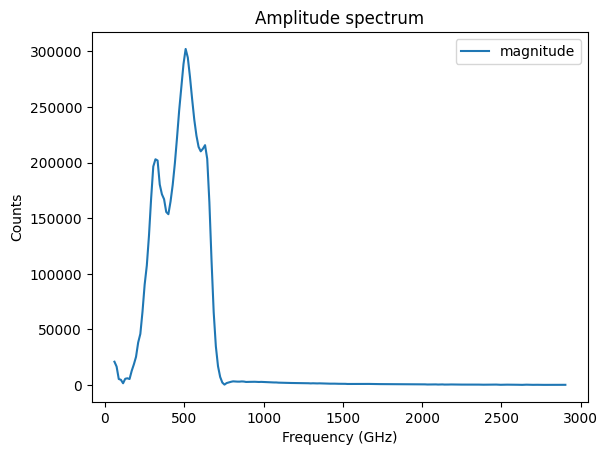

In [176]:
y = np.fft.rfft(padded)
print(y.real.shape)

# to do: roll and put real and imag

# plt.plot(f, y.real[:210], label="real")
# plt.plot(f, y.imag[:210], label="imag") 
plt.plot(f, np.abs(y)[:210], label='magnitude') # plotting the amplitude spectrum
plt.xlabel("Frequency (GHz)")
plt.ylabel("Counts")
plt.title("Amplitude spectrum")
plt.legend()
plt.show()

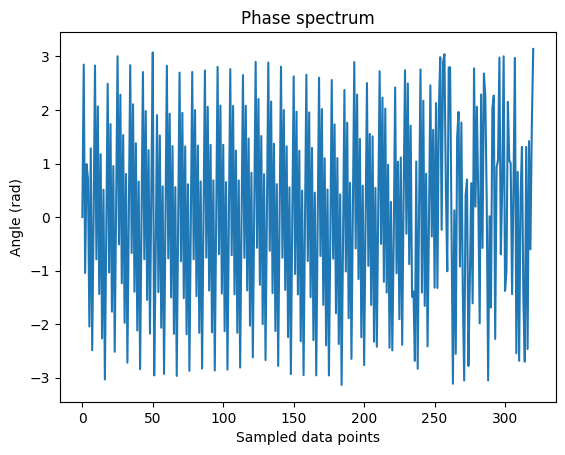

In [177]:
plt.plot(np.angle(y)) # plotting the phase spectrum
plt.xlabel("Sampled data points")
plt.ylabel("Angle (rad)")
plt.title("Phase spectrum")
plt.show()

Electronics transfer function to get the volts

In [178]:
delta_nu = nu[1] - nu[0]
spec_len = len(ifg_ll) // 2
fac_nyq_correct = 1.0044579 # from fex_nyquist.txt
# fnyq_icm = delta_nu * spec_len / fac_nyq_correct # from nathan's pipeline
fnyq_icm = f_nyquist # from explanatory supplement

fac_etendu = 1.5 # nathan's pipeline
fac_adc_scale = 204.75 # nathan's pipeline

spec_norm = fnyq_icm * fac_etendu * fac_adc_scale

(321,) (321,) ()


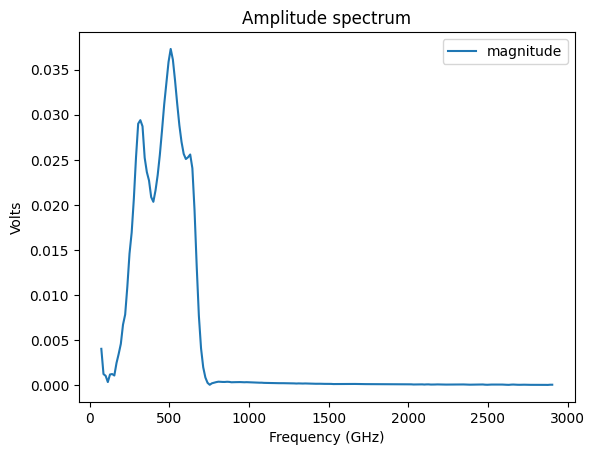

In [179]:
print(y.shape, etf.shape, spec_norm.shape)

yz = y / (etf * spec_norm) * u.V

# plt.plot(f, yz.real[:210], label="real")
# # plt.plot(f, yz.imag[:210], label="imag")
plt.plot(f, np.abs(yz)[:210], label='magnitude') # plotting the amplitude spectrum
plt.xlabel("Frequency (GHz)")
plt.ylabel("Volts")
plt.title("Amplitude spectrum")
plt.legend()
plt.show()

In [213]:
yz = yz.to("erg/s")

UnitConversionError: 'V cm' and 'erg / s' (power/radiant flux) are not convertible

In [180]:
# plt.plot(np.angle(yz)) # plotting the phase spectrum
# plt.ylabel("Angle (rad)")
# plt.title("Amplitude spectrum")
# plt.show()

Bolometer model

In [181]:
# fits_high = fits.open('FIRAS_CALIBRATION_MODEL_LHSS.FITS')
fits_data[1].header

XTENSION= 'BINTABLE'           / Extension type is Binary Table                 
BITPIX  =                    8 / Binary data                                    
NAXIS   =                    2 / Data are in a table                            
NAXIS1  =                15600 / Number of 8 bit bytes in each row              
NAXIS2  =                    1 / Number of rows                                 
PCOUNT  =                    0 / Number of bytes of data following table        
GCOUNT  =                    1 / Group count (always 1 for bintable extensions) 
TFIELDS =                   45 / Number of fields (columns) in the table        
COMMENT                                                                         
COMMENT                                                                         
COMMENT    FIRAS Calibration Model Solution                                     
COMMENT    Project Dataset Record Structure                                     
COMMENT                     

In [182]:
S0 = fits_data[1].data['DC_RESPO'][0] * u.V / u.W

In [183]:
domega = 2.2299744 * u.rad / u.s
omega = np.arange(210) * domega + 11.149872 * u.rad / u.s

In [184]:
bolometer = S0 / (1 + 1j * omega.value * tau.value)

W cm


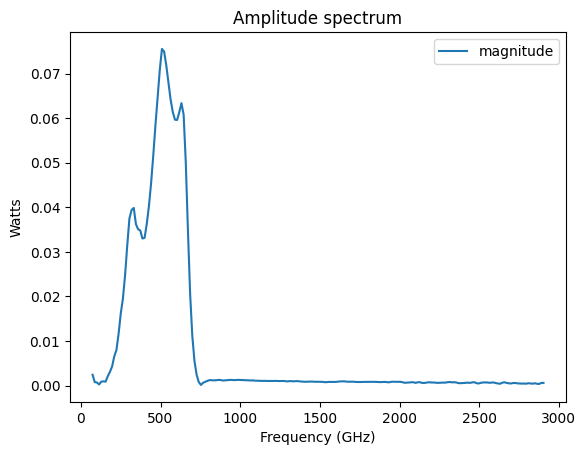

In [185]:
yzb = yz[:210] / bolometer[:210]
print(yzb.unit)

# plt.plot(f, yzb.real[:210], label='real')
# plt.plot(f, yzb.imag[:210], label='imag') 
plt.plot(f, np.abs(yzb)[:210], label='magnitude') # plotting the amplitude spectrum
plt.xlabel("Frequency (GHz)")
plt.ylabel("Watts")
plt.title("Amplitude spectrum")
plt.legend()
plt.show()

In [186]:
# plt.plot(np.angle(yzb)) # plotting the phase spectrum
# plt.ylabel("Angle (rad)")
# plt.title("Amplitude spectrum")
# plt.show()

Cut off high frequencies

Mapping of correct frequencies to the points in the IFG and the given functions (OTF, etc)?

In [187]:
cutoff = yzb[:43]

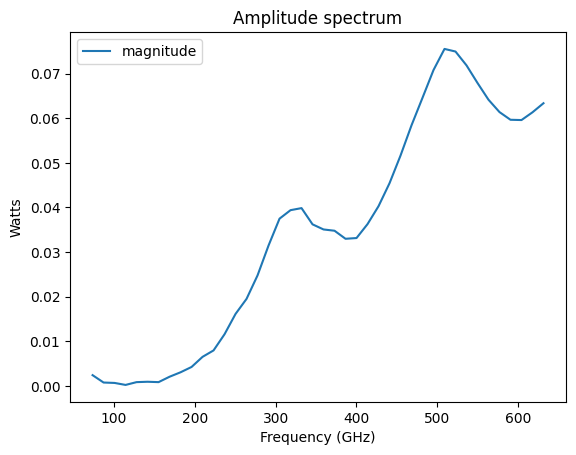

In [188]:
# plt.plot(f[:43], cutoff.real, label='real')
# plt.plot(f[:43], cutoff.imag, label='imag')
plt.plot(f[:43],np.abs(cutoff), label='magnitude') # plotting the amplitude spectrum
plt.xlabel("Frequency (GHz)")
plt.ylabel("Watts")
plt.title("Amplitude spectrum")
plt.legend()
plt.show()

todo: missing vibration and corrections terms

Optical transfer function

43

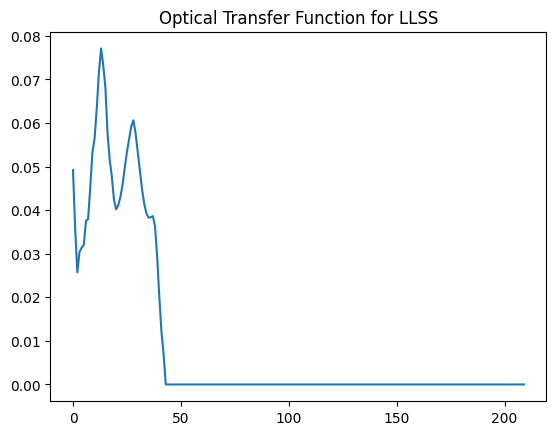

In [189]:
otf = fits_data[1].data["RTRANSFE"][0] + 1j * fits_data[1].data["ITRANSFE"][0]

plt.plot(np.abs(otf)) # plotting the amplitude spectrum
plt.title("Optical Transfer Function for LLSS")
len(otf[np.abs(otf) > 0])

In [190]:
# otf_high = fits_high[1].data["RTRANSFE"][0] + 1j * fits_high[1].data["ITRANSFE"][0]
# plt.plot(np.abs(otf_high)) # plotting the amplitude spectrum
# plt.title("Optical Transfer Function for LHSS")
# len(otf[np.abs(otf_high) > 0])

Why do we need to force the unit? Shoudldn't the OTF come with units? -- Problem with getting $D(\nu)$ into the right units

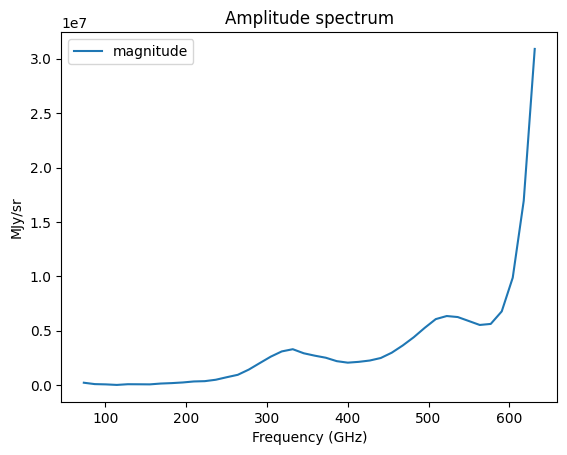

In [193]:
yzbh = cutoff / otf[:43]
# yzbh = yzbh.value * u.MJy / u.sr
yzbh = yzbh.value * u.erg / u.s / u.cm**2 / u.sr * u.cm

# is this actually in ergs/sec/cm**2/sr/icm? (fsl)
fac_icm_ghz = 29.9792458
fac_erg_to_mjy = 1.0e8 / fac_icm_ghz

yzbh = yzbh * fac_erg_to_mjy
yzbh = yzbh.value * u.MJy / u.sr

# plt.plot(f[:43], yzbh.real, label='real')
# plt.plot(f[:43], yzbh.imag, label='imag')
plt.plot(f[:43], np.abs(yzbh), label='magnitude') # plotting the amplitude spectrum
plt.title("Amplitude spectrum")
plt.xlabel("Frequency (GHz)")
plt.ylabel("MJy/sr")
plt.legend()
plt.show()

In [194]:
phase = 1e-5 * u.cm

d = np.exp(1j*nu[:43]*phase) * yzbh
d.unit

Unit("MJy / sr")

todo: recheck this?

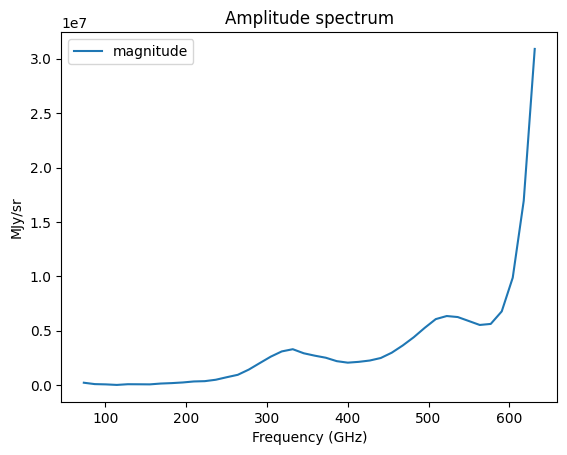

In [195]:
# plt.plot(f[:43], d.real, label='real')
# plt.plot(f[:43], d.imag, label='imag')
plt.plot(f[:43], np.abs(d), label='magnitude') # plotting the amplitude spectrum
plt.title("Amplitude spectrum")
plt.xlabel("Frequency (GHz)")
plt.ylabel("MJy/sr")
plt.legend()
plt.show()

In [196]:
(0.1 * (u.erg * 1e-6) / u.cm**2 / u.s / u.sr / u.cm).to(u.MJy / u.sr, equivalencies=u.spectral_density(1 * u.cm))

<Quantity 0.3335641 MJy / sr>

In [197]:
ical_emiss = fits_data[1].data["RICAL"][0] + 1j * fits_data[1].data["IICAL"][0]

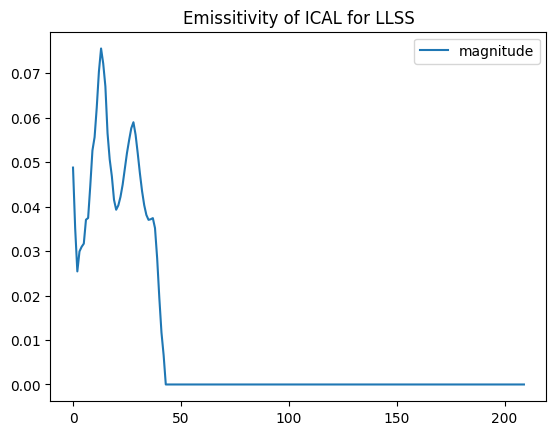

In [198]:
# plt.plot(ical_emiss.real, label='real')
# plt.plot(ical_emiss.imag, label='imag')
plt.plot(np.abs(ical_emiss), label='magnitude') # plotting the amplitude spectrum
plt.title("Emissitivity of ICAL for LLSS")
plt.legend()
plt.show()

In [199]:
t_ical = data["df_data/ical"][idx] * u.K

bb_ical = (BlackBody(temperature=t_ical)(f[:43]) * ical_emiss[:43]).to(u.MJy / u.sr)
# bb_ical2 = (BlackBody(temperature=t_ical)(f[:43]) * 0.94).to(u.MJy / u.sr)


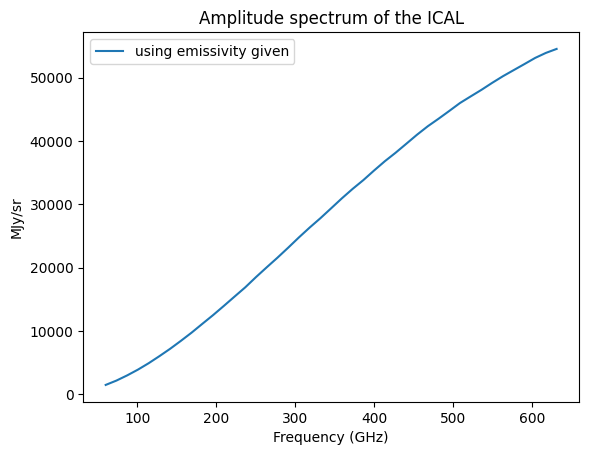

In [200]:
plt.plot(f[:43], np.abs(bb_ical / otf[:43]), label="using emissivity given") # plotting the amplitude spectrum
# plt.plot(f[:43], np.abs(bb_ical2 / otf[:43]), label="using emissivity = 0.94") # plotting the amplitude spectrum
plt.title("Amplitude spectrum of the ICAL")
plt.xlabel("Frequency (GHz)")
plt.ylabel("MJy/sr")
plt.legend()
plt.show()

In [201]:
sky = d + bb_ical / otf[:43]
# sky2 = d + bb_ical2 / otf[:43]

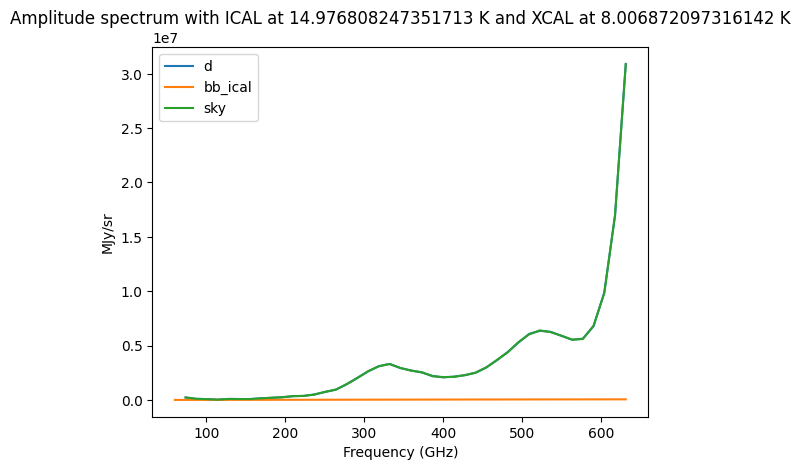

In [202]:
plt.plot(f[:43], np.abs(d), label="d")
plt.plot(f[:43], np.abs(bb_ical / otf[:43]), label="bb_ical")
# plt.plot(f[:43], np.abs(bb_ical2), label="bb_ical2")
plt.plot(f[:43], np.abs(sky), label="sky") # plotting the amplitude spectrum
# plt.plot(f[:43], np.abs(sky2), label="sky2") # plotting the amplitude spectrum
plt.xlabel("Frequency (GHz)")
plt.ylabel("MJy/sr")
plt.title(f"Amplitude spectrum with ICAL at {data["df_data/ical"][idx]} K and XCAL at {data["df_data/xcal"][idx]} K")
plt.legend()
plt.show()

In [203]:
# plt.plot(np.angle(sky1), label='sky1') # plotting the phase spectrum
# plt.plot(np.angle(sky2), label='sky2') # plotting the phase spectrum
# plt.ylabel("Angle (rad)")
# plt.title("Phase spectrum")
# plt.legend()
# plt.show()

### Fitting

In [204]:
def blackbody_model(frequency, temperature):
    bb = BlackBody(temperature * u.K)
    return bb(frequency).to("MJy sr-1").value

p0 = [2.7]
bounds = [(0, 26)]

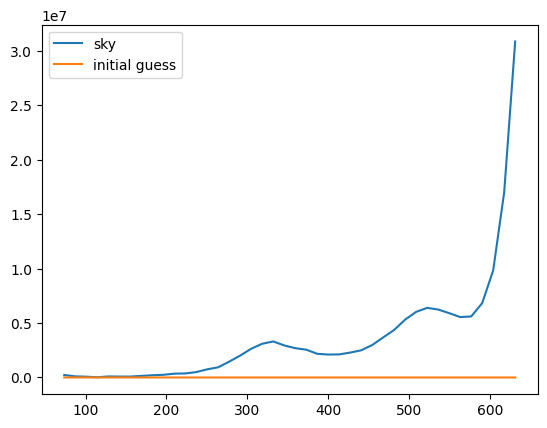

In [205]:
plt.plot(f[1:43], np.abs(sky[1:]), label="sky") # plotting the amplitude spectrum
plt.plot(f[1:43], blackbody_model(f[1:43], p0[0]), label="initial guess")
plt.legend()
plt.show()

In [206]:
# popt, pcov = curve_fit(blackbody_model, f[1:43], np.abs(sky[1:]).value, p0 = p0, bounds=bounds)
# # result = curve_fit(blackbody_model, f[1:43], np.abs(sky[1:43]).value)#, full_output=True)

# print(popt)

# # TOOD: try with minimise, look into full_output

In [207]:
def residuals(temperature, frequency_data, sky_data): # doing least squares for now
    return np.sum((sky_data - blackbody_model(frequency_data, temperature[0]))**2)

In [208]:
result = minimize(residuals, p0, args=(f[1:43], np.abs(sky[1:43]).value), bounds=bounds)
fitted_temperature = result.x[0]

print(f"Fitted temperature: {fitted_temperature} K, real temperature: {data['df_data/xcal'][idx]} K, ICAL temperature: {data['df_data/ical'][idx]} K")

Fitted temperature: 26.0 K, real temperature: 8.006872097316142 K, ICAL temperature: 14.976808247351713 K


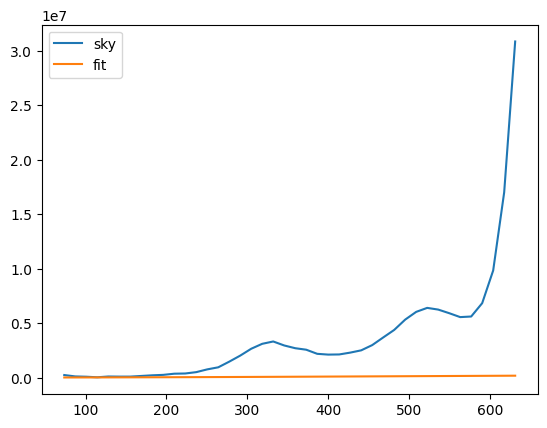

In [209]:
plt.plot(f[1:43], np.abs(sky)[1:], label="sky")
plt.plot(f[1:43], blackbody_model(f[1:43], fitted_temperature), label="fit")
plt.legend()
plt.show()